In [1]:
import pickle

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from numpy import linalg as LA
from sklearn.feature_selection import SelectKBest

from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, hstack
from math import sqrt
import copy
from collections import defaultdict
from collections import Counter

In [2]:
base_path='''E:\Datasets\TWITTER_SOCG\%s'''
file_X = base_path%("travel_X.pkl")
file_y = base_path%("travel_y.pkl")

with open(file_X,"rb") as f:
    X = pickle.load(f)

with open(file_y,"rb") as f:
    y = pickle.load(f)

In [3]:
print("No. of data points = ",len(X),"No. of features = ",len(X[0]))

No. of data points =  3382 No. of features =  2


In [4]:
print(X[0])
## 0 - # of international
## 1 - Erraticism

[0, 0.12268252563295252]


In [5]:
X_new, y_new = [],[]
for x,y in zip(X,y):
    if y != 2:
        X_new.append(x)
        y_new.append(y)

In [6]:
X,y = X_new,y_new
print("No. of data points = ",len(X),"No. of features = ",len(X[0]))

No. of data points =  385 No. of features =  2


## Loading Data

In [7]:
train_df = pd.DataFrame(X)
train_sal_df = pd.DataFrame(y)
train_sal_df.columns = ['Label']

## Data Analysis and Visualization

In [8]:
train_df.head()

,0,1
0,0,0.122683
1,0,0.164246
2,0,0.326664
3,0,0.000000
4,0,0.000000


In [9]:
train_sal_df.head()

,Label
0,0
1,0
2,0
3,0
4,0


In [10]:
df = pd.concat([train_df, train_sal_df], axis=1)

In [11]:
df.head()

,0,1,Label
0,0,0.122683,0
1,0,0.164246,0
2,0,0.326664,0
3,0,0.000000,0
4,0,0.000000,0


In [12]:
train_df.describe()

,0,1
count,385.000000,385.000000
mean,0.324675,0.169871
std,3.567217,0.198696
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.102814
75%,0.000000,0.285907
max,65.000000,0.892262


In [13]:
df.mode(numeric_only=True)

,0,1,Label
0,0,0.0,0


In [16]:
## 0 - Liberals
## 1 - Conservatives

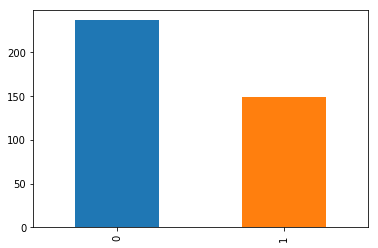

In [14]:
## The distibution between labels 0 and 1
df.groupby('Label', as_index=False).count()[0].plot.bar()

In [15]:
## MEAN usage of a word based on different groups
mean_df = df.groupby('Label', as_index=False).mean()
#mean_df.columns = ["bias","International Travel","Erraticism"]

In [16]:
#mean_df = mean_df.rename(index={0: 'Liberals',1:'Conservatives'})

In [17]:
mean_df.head()

,Label,0,1
0,0,0.516949,0.167152
1,1,0.020134,0.174177


In [44]:
mdf = mean_df.rename(columns={0: 'International Travel',1: 'Erraticism'})
mdf = mdf.rename(index={0: 'Liberals',1:'Conservatives'})

In [45]:
mdf.head()

,Label,International Travel,Erraticism
Liberals,0,0.516949,0.167152
Conservatives,1,0.020134,0.174177


Text(0.5,0,'Classes')

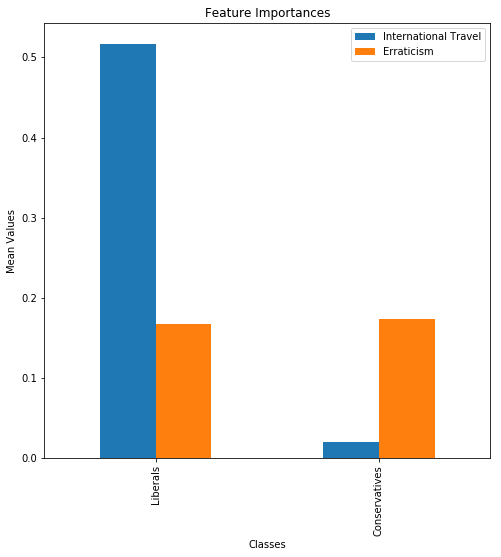

In [46]:
filtered_features = ["International Travel","Erraticism"]
ax = mdf[filtered_features].plot.bar(figsize=(8,8),title="Feature Importances")
ax.set_ylabel("Mean Values")
ax.set_xlabel("Classes")

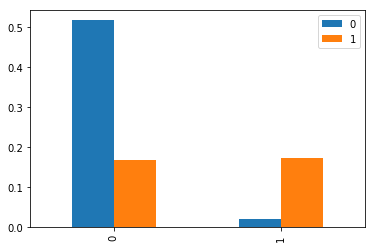

In [47]:
filtered_features = [0,1] 
mean_df[filtered_features].plot.bar()

In [17]:
# for key in key_list:
#     x_plot = [i for i in range(0,len(dict_mapping[key].keys()))]
#     plt.bar(x_plot, list(dict_mapping[key].values()))
#     my_xticks = list(dict_mapping[key].keys())
#     plt.xticks(x_plot, my_xticks, rotation=90)
#     plt.ylabel("Mean Salary")
#     plt.title(key)
#     plt.show()

## Data Processing : Shuffle Data

In [21]:
train_df = df.sample(frac=1).reset_index(drop=True)

In [22]:
train_df.head()

,0,1,Label
0,0,0.000000,0
1,0,0.409847,1
2,0,0.000000,1
3,0,0.285907,0
4,0,0.135200,1


## 1. Baseline Model : Predicting the most occuring label

In [23]:
limit = int(len(y)*0.8)

In [24]:
X_train = train_df[:limit]
y_train = (train_df['Label'])[:limit]
X_test = train_df[limit:]
y_test = (train_df['Label'])[limit:]

baseline = Counter(y_train)
max_val = max(baseline.values())
for b in baseline:
    if baseline[b] == max_val:
        prediction = b

y_pred = [prediction]*len(y_test)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY: ",acc)

ACCURACY:  0.5714285714285714


In [25]:
Counter(y_test)

Counter({0: 44, 1: 33})

## Trying different features

In [26]:
num_df = train_df[[i for i in range(0,2)]]

In [23]:
## Normalization
#num_df = num_df.apply(lambda x: x - np.mean(x) / (np.max(x) - np.min(x)))

In [27]:
num_df.shape

(385, 2)

In [28]:
## Appending a bais term
train_df1 = np.ones((num_df.shape[0],num_df.shape[1]+1))
train_df1[:,1:] = num_df

In [29]:
#train_df1 = train_df_2
train_df1.shape

(385, 3)

In [30]:
X = train_df1
y = train_df['Label']

## Calculating Covariance to see feature importances

In [31]:
covariance = np.cov(X.T)

In [32]:
w, v = LA.eig(covariance)

In [33]:
idx = np.array([i for i in range(0,3)])

In [34]:
sorted_w, sorted_idx = (list(t) for t in zip(*sorted(zip(w, idx), reverse=True)))

In [35]:
print(sorted_idx[:10])
print(sorted_w[:10])

[1, 0, 2]
[12.725157740190358, 0.03936304245090838, 0.0]


In [36]:
print("Top 10 most important features : ")
for i, s in enumerate(sorted_idx[0:10],1):
    if s != 0:
        print(i,"\t: f",s-1)
    else:
        print(i,"\t: b",s)

Top 10 most important features : 
1 	: f 0
2 	: b 0
3 	: f 1


In [37]:
print("Top 10 least important features : ")
for i, s in enumerate(sorted_idx[-10:],1):
    if s != 0:
        print(i,"\t: f",s-1)
    else:
        print(i,"\t: b",s)

Top 10 least important features : 
1 	: f 0
2 	: b 0
3 	: f 1


In [38]:
pca = PCA()
pca.fit(X)
variance_explained = [0]
curr_explained = 0
for v in pca.explained_variance_ratio_:
    curr_explained += v
    variance_explained.append(curr_explained)

In [39]:
num_components = [i for i in range(0,len(variance_explained))]

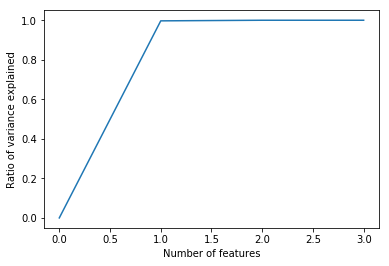

In [40]:
plt.plot(num_components,variance_explained)
plt.xlabel("Number of features")
plt.ylabel("Ratio of variance explained")
plt.show()

In [38]:
## Tried dimensionality reduction but doesn't work very well
# pca = PCA(n_components=5)
# X = pca.fit_transform(X)

In [41]:
## Train Test Split in ratio of 8:2
X_train = X[:limit]
y_train = y[:limit]
X_test = X[limit:]
y_test = y[limit:]

In [42]:
print(np.shape(X_train),np.shape(X_test))

(308, 3) (77, 3)


## 2. Logistic Regression

In [41]:
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY: ",acc)

ACCURACY:  0.6493506493506493


C:\Users\harsh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 3. SVM Classifier

In [42]:
clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY: ",acc)

ACCURACY:  0.6493506493506493


C:\Users\harsh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## 4. Nearest Neighbour Classifier

In [43]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY: ",acc)

ACCURACY:  0.6103896103896104


## 5. Decision Tree Classifier

In [44]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY: ",acc)

ACCURACY:  0.6233766233766234


## ===============================================================================

In [45]:
import pydotplus
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 

In [47]:
# from graphviz import Digraph
# dot = Digraph(comment='The Round Table')
# dot  #doctest: +ELLIPSIS

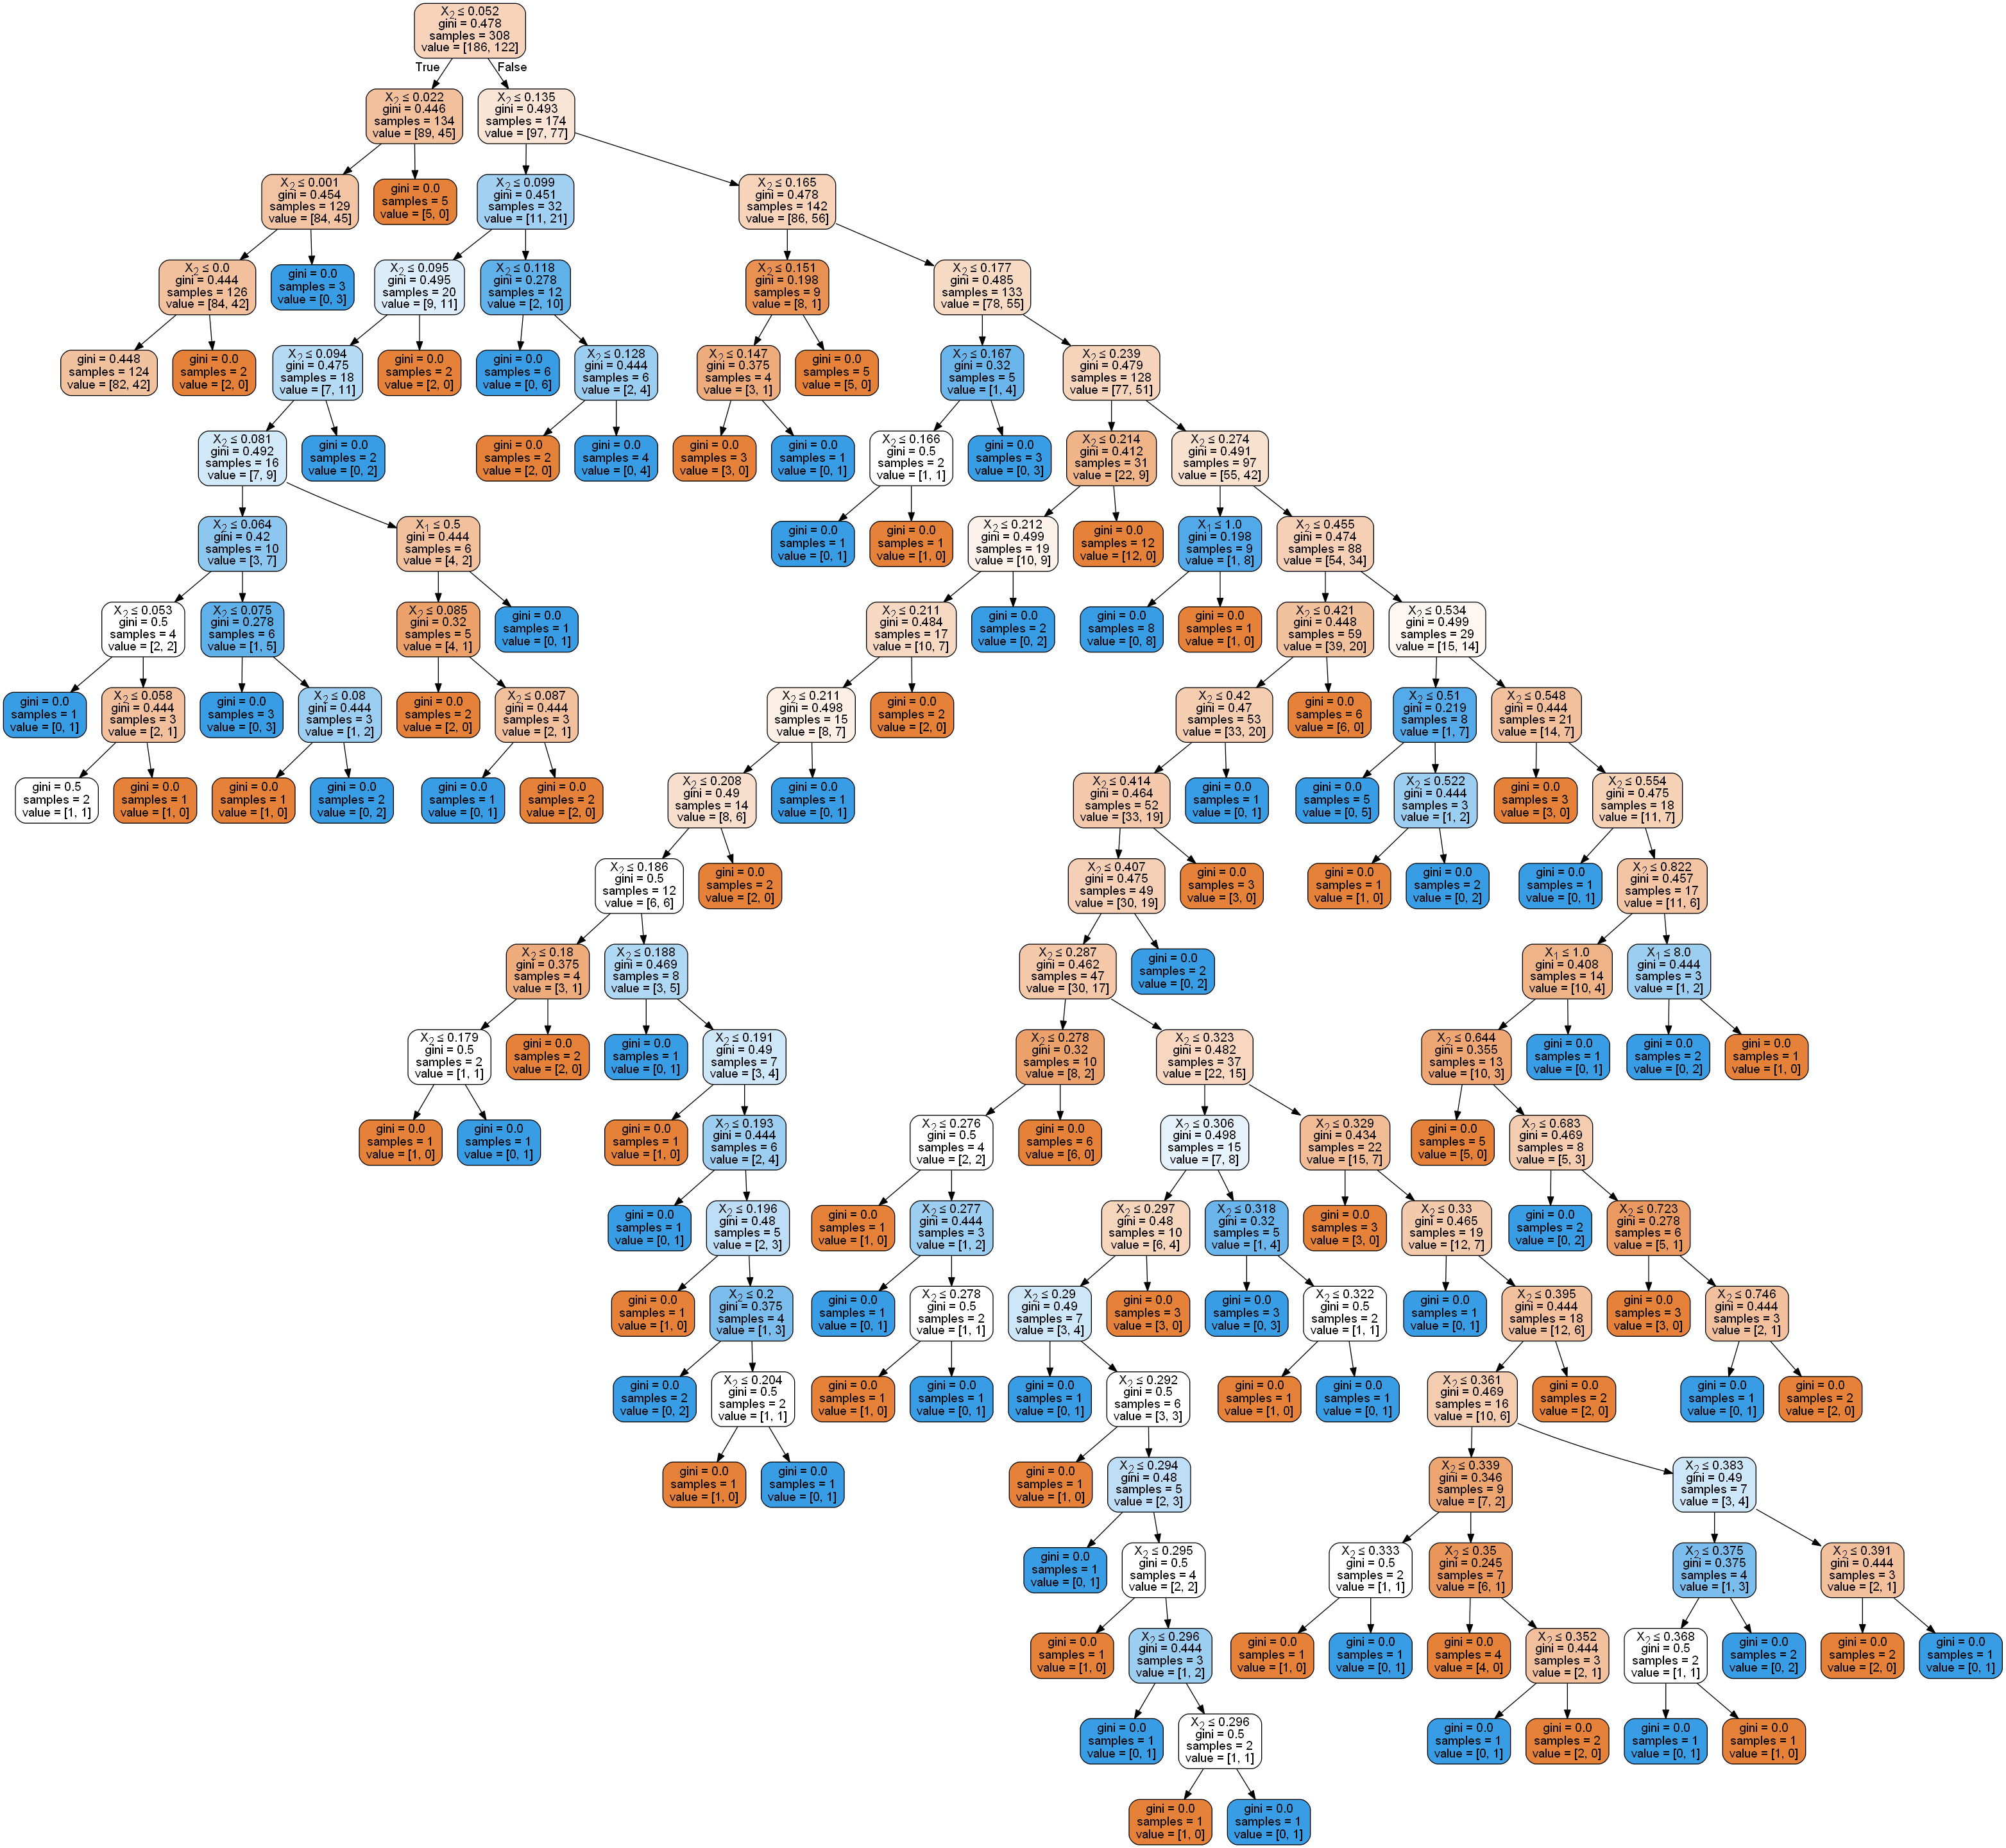

In [48]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## ===============================================================================

## 6. Random Forest Classifier

In [111]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(X_train, y_train.values)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY: ",acc)

ACCURACY:  0.6623376623376623


## 7. Gaussian Process Classifier

## 8. SGD Classifier

In [112]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY: ",acc)

ACCURACY:  0.6623376623376623


## 9. Boosting algorithm classifier

In [113]:
clf = clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=3, random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY: ",acc)

ACCURACY:  0.6623376623376623


## 10. Naive Bayes Classifier

In [114]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("ACCURACY: ",acc)

ACCURACY:  0.33766233766233766
